# cesm Rainfall Anomalies

In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.timePeriod as tp

In [2]:
import xarray
import numpy
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnchoredText
import cartopy.io.shapereader as shpr

%matplotlib inline

In [3]:
secondsPerDay = 60*60*24
secondsToTimeP = secondsPerDay*1000 #seconds per day, convert m to mm
#secondsToTimeP = secondsPerDay*_index.nDaysOfInterest["precAnom"]*1000/7 #seconds per month

# Calculate a climatology

Based on the control run, calculate monthly anomalies

In [ ]:
preclDa = fh.loadModelData('CESM-LME', 'PRECL', _model.cesmCntl)
preccDa = fh.loadModelData('CESM-LME', 'PRECC', _model.cesmCntl)


prectDa = (preclDa.PRECL+preccDa.PRECC)
prectDa.name='prect'

In [ ]:
monMeansDa=prectDa.groupby('time.month').mean(dim='time')

monMeansDa.where(
        (monMeansDa.lat>-50) & (monMeansDa.lat<0) & (monMeansDa.lon>100) & (monMeansDa.lon<170),
        drop=True
    ).load()

# What area am I interested in

In [4]:
cities=shpr.Reader(shpr.natural_earth(resolution='110m', category='cultural', name='populated_places'))

citNames=list()
citLat=list()
citLon=list()
for i in cities.records():
    citNames.append(i.attributes['NAME'])
    citLat.append(i.attributes['LATITUDE'])
    citLon.append(i.attributes['LONGITUDE'])

In [5]:
import os
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/Users/ajs/compound/ref/"

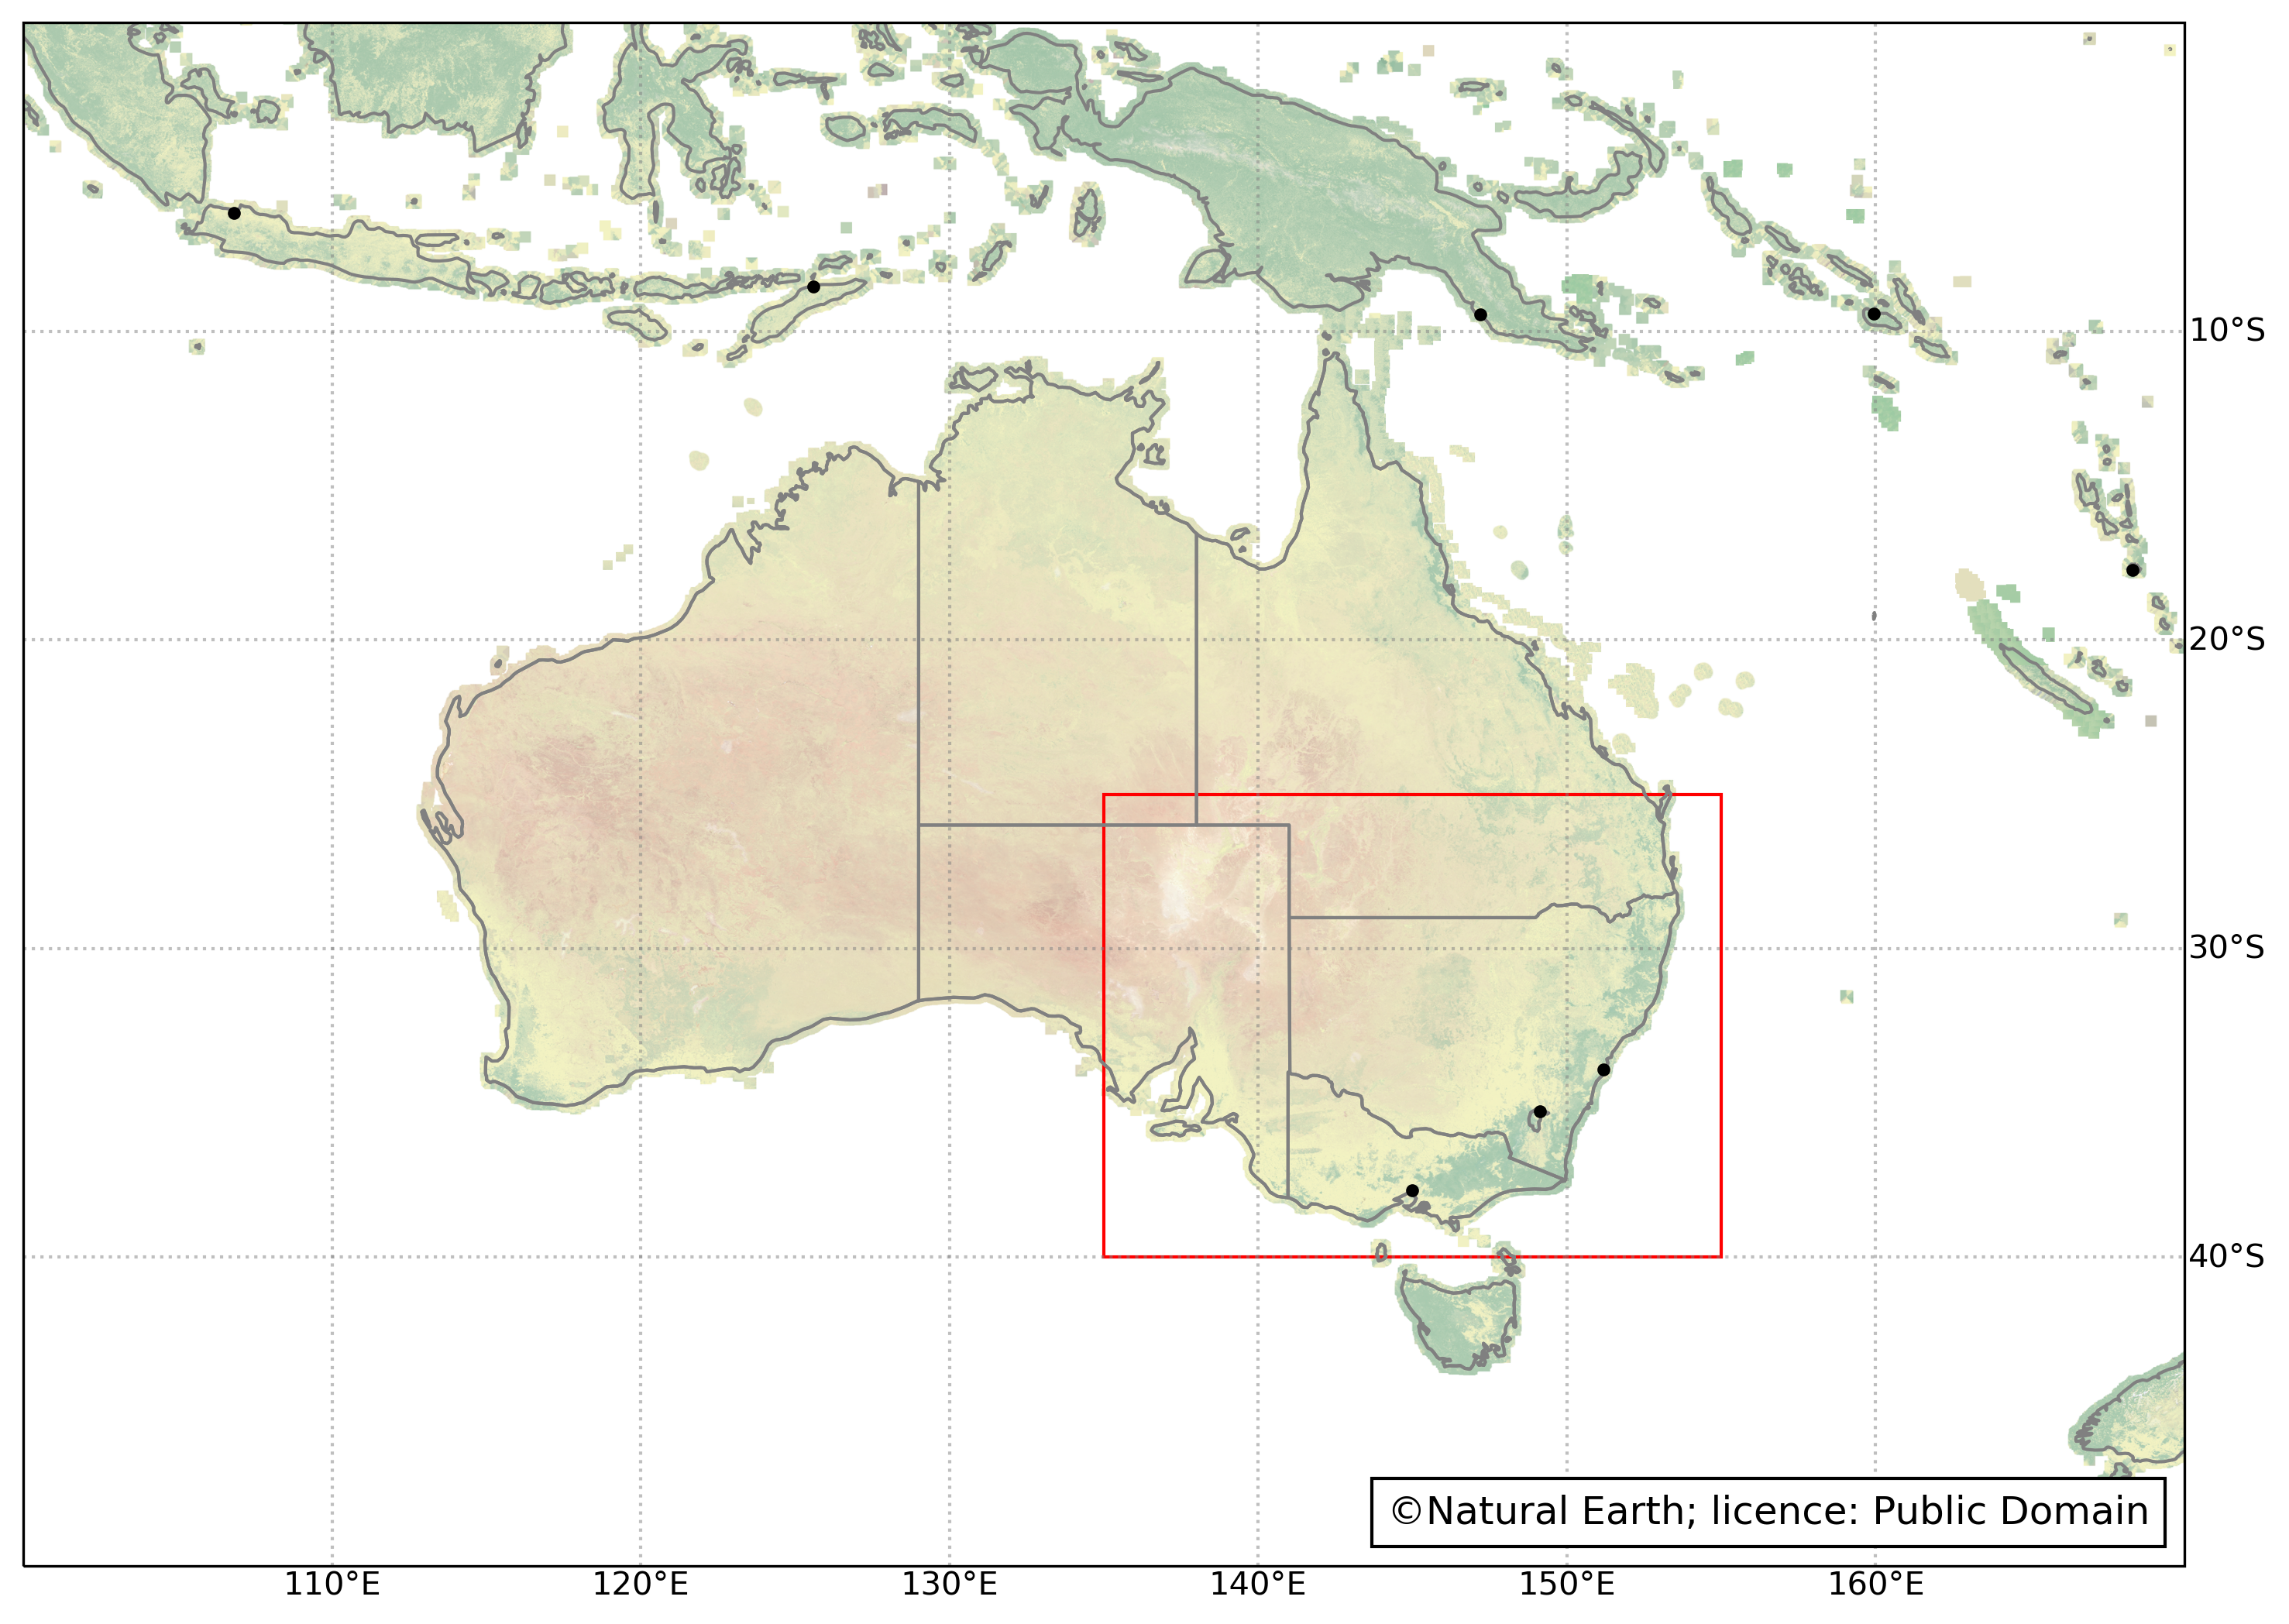

In [9]:
fig=plt.figure(figsize=(12,12), dpi=300)

ax=fig.add_subplot(projection=ccrs.PlateCarree())

ax.background_img(name="NE1", resolution="low")

ax.set_xlim(100,170)
ax.set_ylim(-50,0)

gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.top_labels=False
gl.left_labels=False


#credit: https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
ax.add_feature(cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='50m',
        facecolor='none'), edgecolor='grey')

ax.add_feature(cfeature.OCEAN) 

ax.coastlines(color='grey')

ax.plot(citLon, citLat, '.', color='black', label=citNames, transform=ccrs.PlateCarree())

ax.add_patch(mpatches.Rectangle(xy=[135, -40], width=20, height=15,
                                edgecolor='red',facecolor='none' ))



# Add a text annotation for the license information to the
    # the bottom right corner.
text = AnchoredText(u"\u00A9" + "Natural Earth; licence: Public Domain",
                        loc=4, prop={'size': 12}, frameon=True)
ax.add_artist(text)

plt.show()

# Carve out an area of interest, and calculate anomalies

In [ ]:

for experiment in [*_model.cesmFullForcings, _model.cesmCntl]:
    
    #load it
    preclDa = fh.loadModelData('CESM-LME', 'PRECL', experiment)
    preccDa = fh.loadModelData('CESM-LME', 'PRECC', experiment)
    prectDa = (preclDa.PRECL+preccDa.PRECC)
    prectDa.name='prect'
    
    #anom
    anomDa=prectDa.groupby('time.month')-monMeansDa
    anomDa.name='precAnom'
        
    #grab area around Australia
    domainDa=anomDa.where(
        (anomDa.lat>-50) & (anomDa.lat<0) & (anomDa.lon>100) & (anomDa.lon<170),
        drop=True
    )
    
    # convert to mm/year and store
    domainDa.to_netcdf('results/cesmMonthlyPrec/'+experiment+'.nc')
    
     #rcp85 extensions
    if experiment in ['002','003', '008', '009']: 
        
        #extensions
        preclDa = fh.loadModelData('CESM-LME', 'PRECL', 'LME.'+experiment)
        preccDa = fh.loadModelData('CESM-LME', 'PRECC', 'LME.'+experiment)
        extPrectDa = (preclDa.PRECL+preccDa.PRECC)
        extPrectDa.name='prect'
        
        prectDa = xarray.concat([prectDa, extPrectDa], 'time')


        #anom
        anomDa=prectDa.groupby('time.month')-monMeansDa
        anomDa.name='precAnom'

        #grab area around Australia
        domainDa=anomDa.where(
            (anomDa.lat>-50) & (anomDa.lat<0) & (anomDa.lon>100) & (anomDa.lon<170),
            drop=True
        )

        #  store
        domainDa.to_netcdf('results/cesmMonthlyPrec/LME.'+experiment+'.nc')
        
    
    

# Time averaging for the anomalies

In [ ]:
monthlyAnomDa=xarray.concat([
    xarray.open_dataset('results/cesmMonthlyPrec/'+iExp+'.nc') for iExp in _model.cesmAll],
    'experiment')
    

monthlyAnomDa=monthlyAnomDa.assign({'experiment':_model.cesmAll})


warmSeasonAnomDa=secondsToTimeP*tp.averageForTimePeriod(monthlyAnomDa)
warmSeasonAnomDa = warmSeasonAnomDa.assign_attrs([*warmSeasonAnomDa.attrs, ('units','mm/month'), ('timePeriod','Warm Season')])

In [ ]:
warmSeasonAnomDa.to_netcdf('results/cesmPrecAnoms.nc')

# Do that all again for Ts

In [ ]:
tsDa = fh.loadModelData('CESM-LME', 'TS', _model.cesmCntl)

monMeansDa=tsDa.TS.groupby('time.month').mean(dim='time')

monMeansDa.where(
        (monMeansDa.lat>-50) & (monMeansDa.lat<0) & (monMeansDa.lon>100) & (monMeansDa.lon<170),
        drop=True
    ).load()

# Carve out an area of interest, and calculate anomalies

In [ ]:

for experiment in [*_model.cesmFullForcings, _model.cesmCntl]: #
    
    #load it
    tsDa = fh.loadModelData('CESM-LME', 'TS', experiment).TS
    
    #anom
    anomDa=tsDa.groupby('time.month')-monMeansDa
    anomDa.name='tsAnom'
        
    #grab area around Australia
    domainDa=anomDa.where(
        (anomDa.lat>-50) & (anomDa.lat<0) & (anomDa.lon>100) & (anomDa.lon<170),
        drop=True
    )
    
    # convert to mm/year and store
    domainDa.to_netcdf('results/cesmMonthlyTs/'+experiment+'.nc')
    
     #rcp85 extensions
    if experiment in ['002','003', '008', '009']: 
        
        #extensions
        extTsDa = fh.loadModelData('CESM-LME', 'TS', 'LME.'+experiment)
        tsDa=xarray.concat([tsDa, extTsDa.TS], 'time')

        #anom
        anomDa=tsDa.groupby('time.month')-monMeansDa
        anomDa.name='tsAnom'

        #grab area around Australia
        domainDa=anomDa.where(
            (anomDa.lat>-50) & (anomDa.lat<0) & (anomDa.lon>100) & (anomDa.lon<170),
            drop=True
        )

        domainDa.to_netcdf('results/cesmMonthlyTs/LME.'+experiment+'.nc')
        
    
    

# Time averaging for the anomalies

In [ ]:
monthlyAnomDa=xarray.concat([
    xarray.open_dataset('results/cesmMonthlyTs/'+iExp+'.nc') for iExp in _model.cesmAll],
    'experiment')
    

monthlyAnomDa=monthlyAnomDa.assign({'experiment':_model.cesmAll})

warmSeasonAnomDa=tp.averageForTimePeriod(monthlyAnomDa)

warmSeasonAnomDa.to_netcdf('results/cesmTsAnoms.nc')